# Semestrální práce BI - MVI  kovarm46
- Tato semestrální páce se bude zabývat užitím metod hlubokého učení na hudebních datech
- Konkrétně bude využit dataset z webu [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)
- Dataset obsahuje celkem 1000 30 sekundových úryvků písní, které jsou roztřízeny do 10 kategorií
- V této práci se pokusím naučit embedding písní. Cílem bude aby tento embedding co nejvíce odpovídal podobnosti písní ve smyslo Cosinové vzdálenosti
- Jako modely, pro naučení embeddingu budou použity:
  - Klasický konvoluční autoenkoder s MSE jako ztrátovou funkcí
  - Konvoluční enkodér s použítím Triplet loss ztrátové funkce
  - Konvoluční enkodér s RNN se ztrátovou funkcí Triplet loss

# 1) Příprava prostředí

## 1.1) Import knihoven
- v této práci budeme pracovat se zvukovými daty, pro jejich zpracování, tedy převod na spektrogramy využijeme knihovnu `librosa`
- Pro vizualizace bude použita knihovna `matplotlib`
- Pro tvorbu neuronové sítě bude využita knihovna `pytorch`

In [1]:
import os
import math
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import umap

import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2) **Příprava a načtení dat**
- Data načteme rovnou do spektrogramů pomocí knihovny `librosa`

## 2.1) **Tvorba dataset objektu**
- Pro usnadnění práce s daty se v Pytorchi používají objekty `Dataset`
- Pro tuto práci si připrávíme dva druhy datasetů
  - `SpectrogramDatase` - který pomocí metody get_item vrací prvek z datasetu a jeho label
  - `TripletSpectrogramDataset` - wraper předešlého datasetu, který vrací trojici:
    - A - anchor
    - P - positive - bod, který má stejný label jako anchor
    - N - negative - bod, který má různý label od anchoru

    Tento dataset je používán při výpočtu TripletLoss function

- Při načtání dat z obou datasetů, se data normalizují pomocí Min-Max normalizace

In [4]:
import os
import numpy as np
import torch
from collections import defaultdict
from torch.utils.data import Dataset

class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, target_length=1292, max=None, min=None):
        """
        Expects path to root of spectrograms directory as root_dir.
        Optionally accepts mean and std for normalization.
        """
        self.data = []
        self.labels = []
        self.label2idx = {}
        self.idx2label = {}
        self.label_index = defaultdict(list)
        self.target_length = target_length
        self.max = max
        self.min = min

        genres = sorted(os.listdir(root_dir))
        for idx, genre in enumerate(genres):
            genre_path = os.path.join(root_dir, genre)
            if not os.path.isdir(genre_path):
                continue

            self.label2idx[genre] = idx # converting numeric to real word cathegory
            self.idx2label[idx] = genre

            for file in os.listdir(genre_path):
                if file.endswith('.npy'):
                    path = os.path.join(genre_path, file)
                    self.data.append((path, idx))
                    self.label_index[idx].append(len(self.data)-1)

    def __len__(self):
        return len(self.data)

    def normalize_init(self, max, min):
      self.max = max
      self.min = min

    def __getitem__(self, idx):
        path, label = self.data[idx]
        spec = np.load(path).astype(np.float32)  # load on-the-fly

        # normalize if mean and std are given
        if self.max is not None and self.min is not None:
            spec = (spec - self.min) / (self.max - self.min)

        spec = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)
        spec = self.pad_or_crop(spec, self.target_length)
        return spec, label

    def pad_or_crop(self, spec, target_length):
        current_length = spec.shape[-1]
        if current_length == target_length:
            return spec
        elif current_length < target_length:
            pad_amount = target_length - current_length
            spec = torch.nn.functional.pad(spec, (0, pad_amount))  # pad last dimension
        else:
            spec = spec[:, :, :target_length]
        return spec


In [5]:
"""Wrapper for SpectrogramDataset"""
class TripletSpectrogramDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.base = subset.dataset # shallow copy!
        self.indices = subset.indices

        self.label_index = defaultdict(list) # stores for each label indexes to original dataset
        for local_idx, dataset_idx in enumerate(self.indices):
            # Get label by calling the base dataset's __getitem__
            _, label = self.base[dataset_idx]  # This calls __getitem__ properly
            self.label_index[label].append(local_idx)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, local_idx):
        dataset_idx = self.indices[local_idx]
        anchor, label = self.base[dataset_idx]

        # Positive: same label, different sample
        if len(self.label_index[label]) < 2:
            # Edge case: only one sample of this label, use same sample
            positive = anchor
        else:
            pos_local_idx = local_idx
            while pos_local_idx == local_idx:
                pos_local_idx = np.random.choice(self.label_index[label])
            pos_global_idx = self.indices[pos_local_idx]
            positive, _ = self.base[pos_global_idx]

        # Negative: different label
        neg_label = np.random.choice([l for l in self.label_index.keys() if l != label])
        neg_local_idx = np.random.choice(self.label_index[neg_label])
        neg_global_idx = self.indices[neg_local_idx]
        negative, _ = self.base[neg_global_idx]

        return anchor, positive, negative

## **2.2) Tvorba spektrogramů**
- Jak bylo zmíněno, tak se používá knihovna librosa
- Pro opakované spuštění jsou při prvním načtění spektrogramy uloženy do adresáře spektrograms
- Dochází k převodu apmlitudy v čase na rozprostření frekvencí v písní a hlasitosi
- Hodnoty v spektrogramu převádíme na **logaritmickou** škálu - do decibelů

In [6]:
data_path = '/content/drive/MyDrive/genres_original'
subdirectory_names = os.listdir(data_path)

if ('spectrograms' not in subdirectory_names):
  #create spectograms folder
  spectrograms_path = os.path.join(data_path, 'spectrograms')

  os.makedirs(spectrograms_path, exist_ok=True)

  subdirectory_names = os.listdir(data_path)

  if 'spectrograms' in subdirectory_names:
      subdirectory_names.remove('spectrograms')

  for subdir in subdirectory_names:
      os.makedirs(os.path.join(spectrograms_path, subdir), exist_ok=True)

  #load data
  for subdir in subdirectory_names:
    source_path = data_path+ '/' + subdir
    save_folder = spectrograms_path + '/' + subdir
    for file in os.listdir(source_path):
      try:
        y, sr = librosa.load(source_path + '/' + file, sr=22050)
      except Exception as e:
        print(f"skipping file {file}")
        continue

      S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
      S_dB = librosa.power_to_db(S, ref=np.max)

      filename_no_ext = os.path.splitext(file)[0]
      save_path = os.path.join(save_folder, filename_no_ext + '.npy')

      np.save(save_path, S_dB)

## **2.3) Rozdělení dat a Normalizace**
V této fázi připravíme data tak, aby byla vhodná pro vstup do neuronové sítě a abychom zajistili korektní vyhodnocení výsledků.

* **Rozdělení datasetu (Train/Val/Test split):**
    Abychom předešli tzv. **data leakage** a overfittingu, je nutné data striktně rozdělit. Vytvoříme instanci našeho `Datasetu` a pomocí náhodného výběru ji rozdělíme na tří podmnožiny (`Subset`): trénovací, validační a testovací.

* **Normalizace dat:**
    Neuronové sítě pracují nejefektivněji s daty v malém rozsahu.
    Proto aplikujeme **Min-Max normalizaci**, která transformuje hodnoty do intervalu **[0, 1]**.
    
    Tento krok je klíčový ze dvou důvodů:
    1.  **Stabilita:** Zabraňuje divergenci a urychluje konvergenci gradientního sestupu.
    2.  **Architektura:** Umožňuje nám použít na výstupu autoenkodéru aktivační funkci **Sigmoida**, která přirozeně vrací hodnoty mezi 0 a 1, a tím zajistit kompatibilitu vstupu a výstupu.


In [7]:
df = SpectrogramDataset(data_path + "/spectrograms")

train, val, test = random_split(df, [0.6, 0.2, 0.2])

- Zároveň pro normalizaci je nutné získat minimální a maximální hodnotu z **trénovací**  množiny

In [8]:
global_min = -80
global_max = 0
# all_specs = []

# for elem, label in train.dataset:
#     all_specs.append(elem)

# all_specs = np.concatenate([s.flatten() for s in all_specs])
# global_max = all_specs.max()
# global_min = all_specs.min()

# print(global_max, global_min)

- Nyní už jen zbývá normalizovat datasety a vytvořit `DataLoader` objekt

In [9]:
df.normalize_init(global_max, global_min)

triplet_train_dataset = TripletSpectrogramDataset(train)
triplet_loader = DataLoader(triplet_train_dataset, batch_size=24, shuffle=True)

train_loader = DataLoader(train,batch_size=24,shuffle=False)
val_loader = DataLoader(val, batch_size=24, shuffle=False)
test_loader = DataLoader(test, batch_size=24, shuffle=False)


- Ukázka toho jak vypadají spektrogramy, které se budou neuronové sítě učit.

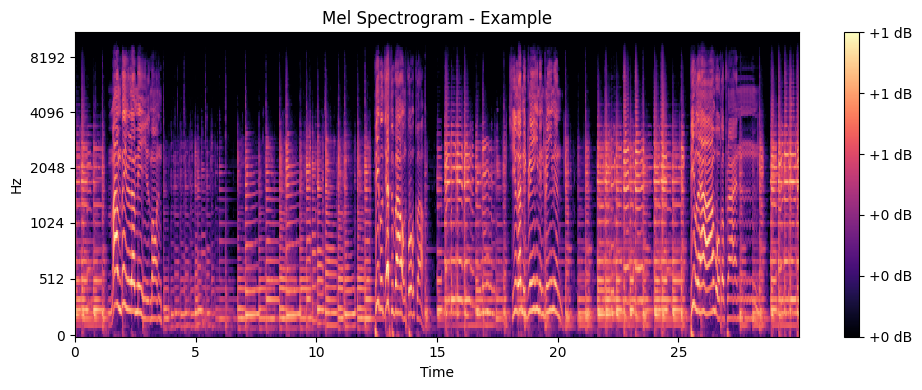

Spectrogram size:  torch.Size([1, 128, 1292])


In [10]:
spec, label = df[0]
np_spec = spec.squeeze(0).numpy()


plt.figure(figsize=(10, 4))
librosa.display.specshow(np_spec, x_axis='time', y_axis='mel', sr=22050)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram - Example')
plt.tight_layout()
plt.show()

print("Spectrogram size: ", spec.shape)


## **2.4) Implementace trénovacích smyček**

Nyní, když máme připravené `DataLoader` objekty, zbývá sestavit poslední část pipeline – samotný trénovací cyklus.

Jelikož každá z námi zvolených architektur (Konvoluční Autoenkodér, Triplet Loss Enkodér, případně VAE) optimalizuje jiný cíl a používá odlišnou ztrátovou funkci, nemůžeme použít jednu univerzální smyčku. Pro každý přístup proto definujeme specifickou trénovací funkci.

### **A) Trénování Autoenkodéru (`train_autoencoder_checkpoint`)**
Pro základní konvoluční autoenkodér je cíl přímočarý: naučit síť komprimovat vstup do latentní dimenze a následně jej co nejpřesněji rekonstruovat.

Jako ztrátovou funkci zde logicky volíme **MSE (Mean Squared Error)**, která penalizuje rozdíl mezi původním spektrogramem a jeho rekonstrukcí.

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = \left( x_n - y_n \right)^2,
$$

kde:
* $x_n$ je vstupní spektrogram (originál).
* $y_n$ je rekonstrukce vytvořená dekodérem.

Funkce zároveň v každé epoše měří přesnost na validačních datech a pokud je dosažena nová nejlepší přesnost, tak je model uložen. Více o měření přesnosti v 5. sekci.

### **B) Trénování s Triplet Loss (`train_autoencoder_triplet`)**
Tento přístup využívá kombinaci **MSE** a tzv. **Metric Learning**. Na rozdíl od běžného autoenkodéru zde využíváme i labely (žánry). Cílem není jen rekonstrukce, ale především to, aby si byly skladby stejného žánru v latentním prostoru "blízko" a skladby rozdílných žánrů "daleko".

K tomu slouží **Triplet Loss**, která pracuje s trojicí vzorků:

$$
\ell(a, p, n) = \max \{d(a, p) - d(a, n) + \text{margin}, 0\}
$$

kde:
* $a$ (**Anchor**): Referenční bod (vybraná skladba).
* $p$ (**Positive**): Jiná skladba stejného žánru jako Anchor.
* $n$ (**Negative**): Skladba odlišného žánru.
* $d$: Funkce vzdálenosti (zpravidla Euklidovská nebo Kosinová).
* **Margin**: Minimální požadovaný rozdíl mezi vzdálenostmi (bezpečnostní zóna).

Kombinace těchto dvou metrik tlačí na tvorbu sémantických embeddingů a zároveň embeddingů, které lze vhodně pomocí dekodéru převést na věrnou reprezentaci vstupu. V této implementaci používám kombinaci: $$\text{MSE} + \lambda \times \text{Triplet loss}$$ kde jako $\lambda$ používám hodnotu 0.01, při prvních experimentech se mi osvědčila jako nejlepší. Při porovnání škál chyb to odpovídá, že MSE je o řád významnější než cosinová vzdálenost.

Díky tomuto přístupu očekáváme, že výsledné embeddingy budou pro účely vyhledávání/reprezentování podobných skladeb vhodnější než u prostého autoenkodéru.

Jako metrika vzdálenosti je použita **cosinová vzdálenost**, která měří odchylku mezi embeddingy. Úhel mezi embeddingy nás zajímá více než euklidovská vzdálenost - chceme aby rozdíl mezi skladbou a její hlasitější kopií byl pokud možno nulový.

Funkce zároveň v každé epoše měří přesnost na validačních datech a pokud je dosažena nová nejlepší přesnost, tak je model uložen. Více o měření přesnosti v 5. sekci.

Co se týče optimalizačních algoritmů gradientního sestupu, tak v této práci byl použit algoritmus `Adam`

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


def evaluate_knn_accuracy(model, train_loader, val_loader, device):
    """Helper to calculate KNN accuracy on the fly
      Fits train_loader embeddings to KNN and makes prediction on val set"""
    model.eval()

    def get_embeddings(loader):
        embeds, labels = [], []
        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x = x.to(device)

                z = model.encode(x)

                embeds.append(z.cpu().numpy())
                labels.append(y.numpy())

        if len(embeds) > 0:
            embeds = np.vstack(embeds)
            labels = np.concatenate(labels)
        return embeds, labels

    train_z, train_y = get_embeddings(train_loader)
    val_z, val_y = get_embeddings(val_loader)

    if len(train_z) == 0 or len(val_z) == 0: return 0.0

    clf = KNeighborsClassifier(n_neighbors=10, metric='cosine')
    clf.fit(train_z, train_y)
    pred = clf.predict(val_z)

    return accuracy_score(val_y, pred)

In [12]:
def train_autoencoder_with_checkpoint(model, train_loader, val_loader, save_path, epochs=100, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    best_metric = 0.0


    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()

            x_hat = model(x)

            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        current_acc = evaluate_knn_accuracy(model, train_loader, val_loader, device)

        print(f"Epoch {epoch+1}/{epochs} | Recon Loss: {avg_loss:.4f} | Val KNN Acc: {current_acc:.4f}")

        if current_acc > best_metric:
            best_metric = current_acc
            print(f"   --> New Best Model! (Improved from {best_metric:.4f} to {current_acc:.4f})")
            torch.save(model.state_dict(), save_path)

    print(f"Training Complete. Best Validation Accuracy: {best_metric:.4f}")
    return model


In [13]:
def train_autoencoder_triplet_with_checkpoint(model, train_loader_triplet, train_loader, val_loader, save_path, epochs=100, lr=1e-3, lambda_triplet=0.01, device='cuda'):
    """
    Training using MSE and Triplet loss, with accuracy mesuring and saving
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    mse_fn = torch.nn.MSELoss()

    #cosine loss definition with cosine distance
    cosine_distance = lambda x, y: 1 - torch.nn.functional.cosine_similarity(x, y)
    triplet_loss_fn = torch.nn.TripletMarginWithDistanceLoss(margin=1.0, distance_function=cosine_distance)

    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_mse = 0
        total_triplet = 0

        for i, (anchor, positive, negative) in enumerate(train_loader_triplet):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            optimizer.zero_grad()

            #---triplet loss calculation----
            a_enc = model.encode(anchor)
            p_enc = model.encode(positive)
            n_enc = model.encode(negative)

            loss_triplet = triplet_loss_fn(a_enc, p_enc, n_enc)

            recon_anchor = model(anchor)

            # --- mse calculation ---
            loss_mse = mse_fn(recon_anchor, anchor)

            loss = loss_mse + (lambda_triplet * loss_triplet)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mse += loss_mse.item()
            total_triplet += loss_triplet.item()

        avg_loss = total_loss / len(train_loader_triplet)
        avg_mse = total_mse / len(train_loader_triplet)
        avg_trip = total_triplet / len(train_loader_triplet)

        # evaluation
        current_acc = evaluate_knn_accuracy(model, train_loader, val_loader, device)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} (MSE: {avg_mse:.4f}, Trip: {avg_trip:.4f}) | Val Acc: {current_acc:.4f}")

        # saving
        if current_acc > best_accuracy:
            best_accuracy = current_acc
            print(f"   --> New Best Model! (Improved from {best_accuracy:.4f} to {current_acc:.4f})")

            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model.state_dict(), save_path)

    print(f"Training Complete. Best Accuracy was: {best_accuracy:.4f}")

# 3) Definice architektur neuronových sítí
V této sekci si představíme třídy reprezentující jednotlivé modely, které budeme trénovat a porovnávat.

## 3.1) Konvoluční Autoenkodér (Baseline)
Tento model slouží jako náš výchozí bod. Jedná se o klasickou architekturu typu **Encoder-Decoder**, kde se síť snaží naučit komprimovanou reprezentaci vstupních dat.

- **Architektura:** Instance třídy `ConvAutoencoder`. Využívá 2D konvoluce pro postupné snižování dimenze (downsampling) do latentního vektoru a následně transponované konvoluce pro rekonstrukci zpět na původní velikost.
- **Ztrátová funkce:** Používáme **MSE (Mean Squared Error)**. Cílem je minimalizovat rozdíl mezi vstupním spektrogramem a jeho rekonstrukcí.

- **Očekávání a limitace:**
  - Neočekáváme, že tento model vytvoří ideální shluky podle žánrů.
  - Jeho hlavním cílem je **vizuální rekonstrukce**, nikoliv pochopení sémantického obsahu hudby.
  - Jedná se o **učení bez učitele** (unsupervised) – model vůbec neví, že existují nějaké hudební žánry, a proto nemá motivaci oddělovat např. rock od popu, pokud mají podobné frekvenční spektrum.

## 3.2) Konvoluční Enkodér s Triplet Loss
Tento model sdílí stejnou konvoluční architekturu jako předchozí autoenkodér (třída `ConvAutoencoder`), ale zásadně se liší ve způsobu učení. Zde přecházíme k tzv. **Metric Learning**.

- **Princip:** Místo rekonstrukce obrázku se model učí přímo manipulovat se vzdálenostmi v latentním prostoru. Využíváme informace o žánrech (supervizované učení).
- **Ztrátová funkce:** Používáme **Triplet Loss**. Tato funkce nutí síť, aby embeddingy skladeb stejného žánru byly k sobě blíž než embeddingy skladeb jiného žánru.

- **Očekávání:** Tento model by měl vytvořit latentní prostor, kde jsou žánry viditelně oddělené do shluků (clusterů).

## 3.3) Hybridní CRNN Enkodér (Konvolučně-Rekurentní)
Třetí přístup reaguje na nedostatek čistě konvolučních sítí – neschopnost efektivně pracovat s časovým vývojem hudby. Spektrogram není jen statický obrázek, ale sekvence, kde záleží na pořadí (rytmus, progrese akordů).

- **Architektura:** Instance třídy `HybridAutoencoder`.
    1.  **CNN část:** Extrahuje texturální příznaky (jaké frekvence znějí) v krátkých časových úsecích.
    2.  **RNN část:** Výstup z CNN je zpracován pomocí **GRU (Gated Recurrent Unit)** vrstev. Tyto vrstvy mají "paměť" a dokážou zasadit aktuální zvuk do kontextu celé skladby (např. poznají rozdíl mezi tichem před dropem a tichem na konci skladby).
- **Výhoda:** Očekáváme, že tento model zachytí i složitější struktury skladeb, které čisté CNN unikají, což by mělo vést k robustnějším embeddingům.

In [14]:
def conv2d_output_size(input_size, kernel_size, stride=1, padding=0, dilation=1):
    return math.floor(((input_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride) + 1)


class ConvAutoencoder(nn.Module):
    def __init__(self,
                 input_size=(128, 1292),
                 input_channels=1,
                 latent_dim=64,
                 hidden_dims=[16, 32, 64],
                 kernel_sizes=[3, 3, 3],
                 paddings=[1, 1, 1],
                 strides=[2, 2, 2],
                 batch_norm = False):
        super().__init__()

        encoder_layers = []
        feature_shapes = []
        channels = input_channels
        h, w = input_size


        # --------building encoder------------
        for i, (dim, kernel, stride, pad) in enumerate(zip(hidden_dims, kernel_sizes, strides, paddings)):
            feature_shapes.append((h, w))
            out_h = conv2d_output_size(h, kernel, stride=stride, padding=pad)
            out_w = conv2d_output_size(w, kernel, stride=stride, padding=pad)
            h, w = out_h, out_w # update current height and width

            #layers
            encoder_layers.append(
                nn.Conv2d(channels, dim, kernel_size=kernel, stride=stride, padding=pad)
            )
            if batch_norm:
                encoder_layers.append(nn.BatchNorm2d(dim))
            encoder_layers.append(nn.ReLU())
            channels = dim


        self.encoder = nn.Sequential(*encoder_layers) # put encoeer together
        self.flatten = nn.Flatten()
        self.encoded_shape = (channels, h, w)

        self.fc1 = nn.Linear(channels * h * w, latent_dim)
        self.fc2 = nn.Linear(latent_dim, channels * h * w)


        # for decoder, we need reverse order of layers, last layer outputs same size as the size of input
        decoder_layers = []
        hidden_dims_rev = hidden_dims[::-1]
        kernel_sizes_rev = kernel_sizes[::-1]
        paddings_rev = paddings[::-1]
        strides_rev = strides[::-1]

        # Start from encoded spatial size
        current_h, current_w = h, w
        channels = hidden_dims_rev[0]

        target_shapes = feature_shapes[::-1]

        for i in range(len(hidden_dims_rev) - 1):
            target_h, target_w = target_shapes[i]

            out_pad_h, out_pad_w = self._get_output_padding(
                current_input_dim=(current_h, current_w),
                desired_output_dim=(target_h, target_w),
                kernel_size=kernel_sizes_rev[i],
                stride=strides_rev[i],
                padding=paddings_rev[i]
            )


            decoder_layers.append(
                nn.ConvTranspose2d(
                    in_channels=channels,
                    out_channels=hidden_dims_rev[i + 1],
                    kernel_size=kernel_sizes_rev[i],
                    stride=strides_rev[i],
                    padding=paddings_rev[i],
                    output_padding=(out_pad_h, out_pad_w)
                ))

            if batch_norm:
                decoder_layers.append(nn.BatchNorm2d(hidden_dims_rev[i + 1]))

            decoder_layers.append(
                nn.ReLU()
            )

            # Update current size
            current_h = target_h
            current_w = target_w
            channels = hidden_dims_rev[i + 1]

        # Final layer: to input size, NO RELU!
        final_target_h, final_target_w = input_size
        out_pad_h, out_pad_w = self._get_output_padding(
            current_input_dim=(current_h, current_w),
            desired_output_dim=(final_target_h, final_target_w),
            kernel_size=kernel_sizes_rev[-1],
            stride=strides_rev[-1],
            padding=paddings_rev[-1]
        )

        decoder_layers += [
            nn.ConvTranspose2d(
                in_channels=channels,
                out_channels=input_channels,
                kernel_size=kernel_sizes_rev[-1],
                stride=strides_rev[-1],
                padding=paddings_rev[-1],
                output_padding=(out_pad_h, out_pad_w)
            ),
            nn.Sigmoid()
        ]

        self.decoder = nn.Sequential(*decoder_layers)
        # print("=== BUILD COMPLETE ===\n")

    @staticmethod
    def _get_output_padding(current_input_dim, desired_output_dim, kernel_size, stride, padding):
        h_in, w_in = current_input_dim
        h_out_desired, w_out_desired = desired_output_dim

        # Compute output without output_padding
        h_calc = (h_in - 1) * stride - 2 * padding + kernel_size
        w_calc = (w_in - 1) * stride - 2 * padding + kernel_size

        # Required output_padding
        pad_h = h_out_desired - h_calc
        pad_w = w_out_desired - w_calc

        return (max(0, pad_h), max(0, pad_w))

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x


    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc1(x)

        x = self.fc2(x)
        x = x.view(x.size(0), *self.encoded_shape)
        x = self.decoder(x)
        return x


In [15]:
class RNNAutoencoder(nn.Module):
    def __init__(self,
                 input_size=(128, 1292),
                 input_channels=1,
                 latent_dim=64,
                 hidden_dims=[16, 32, 64],
                 kernel_sizes=[3, 3, 3],
                 paddings=[1, 1, 1],
                 strides=[2, 2, 2],
                 batch_norm=False,
                 rnn_hidden_dim=128):
        super().__init__()

        self.input_size = input_size
        self.flatten = nn.Flatten()

        # Encoder
        self.encoder_cnn, self.feature_shapes, final_shape = self._build_encoder(
            input_size, input_channels, hidden_dims, kernel_sizes, paddings, strides, batch_norm
        )

        # GRU
        self.encoded_channels, self.encoded_h, self.encoded_w = final_shape

        cnn_flat_size = self.encoded_channels * self.encoded_h * self.encoded_w

        self.rnn_input_size = self.encoded_channels * self.encoded_h
        self.rnn = nn.GRU(
                input_size=self.rnn_input_size,
                hidden_size=rnn_hidden_dim,
                batch_first=True,
                bidirectional=False
        )

        # FC
        self.fc_mu = nn.Linear(rnn_hidden_dim, latent_dim)

        # DECODER
        self.fc_decode_input = nn.Linear(latent_dim, cnn_flat_size) # Map back to full CNN size


        self.decoder_cnn = self._build_decoder(
            input_channels, hidden_dims, kernel_sizes, paddings, strides, batch_norm, self.feature_shapes
        )

    def _build_encoder(self, h_w, in_channels, hidden_dims, kernels, pads, strides, bn):
        """Constructs the Convolutional Encoder Layers
           returns: encoder layers, shapes of inner layers, (output channels, output height, output width)"""
        layers = []
        shapes = []
        h, w = h_w
        c = in_channels

        for dim, k, s, p in zip(hidden_dims, kernels, strides, pads):
            shapes.append((h, w))

            # new shape after passing this layer
            h = conv2d_output_size(h, k, stride=s, padding=p)
            w = conv2d_output_size(w, k, stride=s, padding=p)

            layers.append(nn.Conv2d(c, dim, kernel_size=k, stride=s, padding=p))
            if bn:
                layers.append(nn.BatchNorm2d(dim))
            layers.append(nn.ReLU())

            # new number of channels after passing this layer
            c = dim

        return nn.Sequential(*layers), shapes, (c, h, w)

    def _build_decoder(self, out_channels_final, hidden_dims, kernels, pads, strides, bn, feature_shapes):
        """Constructs the Convolutional Decoder Layers using mirror logic"""
        layers = []

        hidden_dims = hidden_dims[::-1]
        kernels = kernels[::-1]
        pads = pads[::-1]
        strides = strides[::-1]
        target_shapes = feature_shapes[::-1]

        curr_c = hidden_dims[0]
        curr_h, curr_w = self.encoded_h, self.encoded_w

        for i in range(len(hidden_dims) - 1):
            next_dim = hidden_dims[i+1]
            target_h, target_w = target_shapes[i]

            out_pad = self._get_output_padding(
                (curr_h, curr_w), (target_h, target_w), kernels[i], strides[i], pads[i]
            )

            layers.append(
                nn.ConvTranspose2d(curr_c, next_dim, kernels[i], strides[i], pads[i], output_padding=out_pad)
            )
            if bn:
                layers.append(nn.BatchNorm2d(next_dim))

            layers.append(nn.ReLU())

            curr_c = next_dim
            curr_h, curr_w = target_h, target_w

        # filan layer is without relu and batch norm - added separately
        final_h, final_w = self.input_size
        out_pad = self._get_output_padding(
            (curr_h, curr_w), (final_h, final_w), kernels[-1], strides[-1], pads[-1]
        )

        layers.append(
            nn.ConvTranspose2d(curr_c, out_channels_final, kernels[-1], strides[-1], pads[-1], output_padding=out_pad)
        )
        layers.append(nn.Sigmoid())

        return nn.Sequential(*layers)

    @staticmethod
    def _get_output_padding(curr_dim, target_dim, k, s, p):
        h_in, w_in = curr_dim
        h_target, w_target = target_dim

        h_calc = (h_in - 1) * s - 2 * p + k
        w_calc = (w_in - 1) * s - 2 * p + k

        return (max(0, h_target - h_calc), max(0, w_target - w_calc))

    def forward(self, x):
        batch_size = x.size(0)

        x = self.encoder_cnn(x)

        x = x.permute(0, 3, 1, 2)
        x = x.reshape(batch_size, self.encoded_w, -1)

        # first argument are the hidden states after every step
        # second argument is the state after all steps through network - that is what we want
        _, hidden = self.rnn(x)
        # GRU returns 2 layers, last one has the most high level features
        x = hidden[-1]

        embedding = self.fc_mu(x)

        x = self.fc_decode_input(embedding)
        x = x.view(batch_size, self.encoded_channels, self.encoded_h, self.encoded_w)
        reconstruction = self.decoder_cnn(x)

        return reconstruction


    def encode(self, x):
        batch_size = x.size(0)
        x = self.encoder_cnn(x)

        x = x.permute(0, 3, 1, 2)
        x = x.reshape(batch_size, self.encoded_w, -1)

        _, hidden = self.rnn(x)
        x = hidden[-1]

        embedding = self.fc_mu(x)

        return embedding

# 4) Trénování modelů a experimenty

V této kapitole přistoupíme k instanciaci konkrétních architektur a jejich trénování. S využitím připravených tříd a trénovacích smyček provedeme sérii experimentů s různými konfiguracemi hyperparametrů.

**Nastavení trénovacího procesu:**
Délku trénování jsme empiricky stanovili na základě konvergence ztrátové funkce u jednotlivých přístupů:
* **Triplet Loss modely:** 100 epoch.
* **Autoenkodéry (MSE):** 150 epoch (vyžadují delší čas pro jemné doladění rekonstrukce).

### **Klíčové hyperparametry experimentů**
Následující parametry budeme v experimentech měnit, abychom nalezli optimální architekturu pro náš dataset:

* **Hloubka sítě:**
  Určuje schopnost modelu učit se komplexní vztahy. Vzhledem k omezené velikosti našeho datasetu jsme limitováni rizikem **overfittingu**. Proto experimentujeme maximálně se 4 konvolučními bloky, abychom udrželi počet parametrů v rozumných mezích.

* **Batch Normalization:**
  Technika normalizace aktivací mezi vrstvami. Empiricky se ukazuje jako klíčová pro stabilitu trénování hlubších sítí.

* **Kernel Size:**
  Ovlivňuje velikost **reception field**.
  * *Větší kernely (např. 5x5, 7x7):* Vidí širší kontext (delší časový úsek nebo širší frekvenční pásmo) a lépe zachycují globální texturu/barvu zvuku.
  * *Menší kernely (3x3):* Zaměřují se na lokální detaily a hrany.

* **Stride:**
  Určuje agresivitu komprese (downsamplingu) v prostoru. Vyšší stride v prvních vrstvách umožňuje rychle zredukovat časovou dimenzi spektrogramu (z původních 1292 bodů) a snížit výpočetní náročnost.

* **Dimenze embeddingu:**
  Velikost vektoru, do kterého je skladba zakódována. Jedná se o tzv. **bottleneck**.
  * *Příliš malá dimenze:* Může vést ke ztrátě důležitých informací (nedostatečná kapacita pro odlišení žánrů).
  * *Příliš velká dimenze:* Může obsahovat šum a redundantní informace, což ztěžuje shlukování (prokletí dimenzionality).

* **Počet kanálů konvolučních vstev:**
  Určuje, kolik různých "vlastností" (features) je síť schopna v každé vrstvě extrahovat.

In [16]:

# Base configuration, not too deep, not too big kernel, batch norm True
config1 = {
    "latent_dim": 64,
    "hidden_dims": [32, 64, 128, 256],
    "kernel_sizes": [3, 3, 3, 3],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "batch_norm": True
}

# konfigurace s většími kernely - menší důraz na ostré hrany
config2 = {
    "latent_dim": 128, # Larger latent to hold the extra texture info
    "hidden_dims": [16, 32, 64, 128],
    "kernel_sizes": [5, 5, 5, 5],
    "paddings": [2, 2, 2, 2], # Pad 2 is required for Kernel 5
    "strides": [2, 2, 2, 2],
    "batch_norm": True
}

# Velky stride a velky kernel, takze pomerne silna komprese snimku
config3 = {
    "latent_dim": 48,
    "hidden_dims": [32, 64, 128],
    "kernel_sizes": [7, 3, 3],
    "paddings": [3, 1, 1],
    "strides": [4, 2, 2],
    "batch_norm": True
}

#uzky bottleneck  - tlak na semantickou reprezentaci
# V kombinaci s velkym encoderem 512 kanalu v posledni konvolucni vrstve
# Snaha z hodne informace vybrat jen tu podstatnou
config4 = {
    "latent_dim": 32,
    "hidden_dims": [64, 128, 256, 512],
    "kernel_sizes": [3, 3, 3, 3],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "batch_norm": True
}

# stejne jako prvni, bez batch normalizace
config5 = {
    "latent_dim": 64,
    "hidden_dims": [32, 64, 128, 256],
    "kernel_sizes": [3, 3, 3, 3],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "batch_norm": False
}

config6 = {
    "latent_dim": 48,
    "hidden_dims": [32, 64, 128],
    "kernel_sizes": [7, 3, 3],
    "paddings": [3, 1, 1],
    "strides": [4, 2, 2],
    "batch_norm": True,
    "rnn_hidden_dim": 128
}

In [17]:
def save_model(filename, path, model):
  filename = os.path.join(path,filename+".pth")
  torch.save(model.state_dict(), filename)

def load_model(file_path,config,model_type = ConvAutoencoder):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model_type(**config)

    checkpoint = torch.load(file_path, map_location=device)

    model.load_state_dict(checkpoint)


    return model

## 4.1) Klasický konvoluční autoenkodér


In [18]:

model_save_path = '/content/drive/MyDrive/Audio_Autoencoder_Models'

In [19]:
path = os.path.join(model_save_path,"model_conv1.pth")
if not os.path.exists(path):
  model_conv1 = ConvAutoencoder(**config1)
  train_autoencoder_with_checkpoint(model_conv1,train_loader,val_loader,path,device=device,epochs=100)
else:
  model_conv1 = load_model(os.path.join(model_save_path,"model_conv1.pth"),config1)

In [20]:
path = os.path.join(model_save_path,"model_conv2.pth")
if not os.path.exists(path):
  model_conv2 = ConvAutoencoder(**config2)
  train_autoencoder_with_checkpoint(model_conv2,train_loader,val_loader,path,device=device,epochs=100)
else:
  model_conv2 = load_model(os.path.join(model_save_path,"model_conv2.pth"),config2)

In [21]:
path = os.path.join(model_save_path,"model_conv3.pth")
if not os.path.exists(path):
  model_conv3 = ConvAutoencoder(**config3)
  train_autoencoder_with_checkpoint(model_conv3,train_loader,val_loader,path,device=device)
else:
  model_conv3 = load_model(os.path.join(model_save_path,"model_conv3.pth"),config3)

In [22]:
path = os.path.join(model_save_path,"model_conv4.pth")
if not os.path.exists(path):
  model_conv4 = ConvAutoencoder(**config4)
  train_autoencoder_with_checkpoint(model_conv4,train_loader,val_loader,path,device=device)
else:
  model_conv4 = load_model(os.path.join(model_save_path,"model_conv4.pth"),config4)

In [23]:
path = os.path.join(model_save_path,"model_conv5.pth")
if not os.path.exists(path):
  model_conv5 = ConvAutoencoder(**config5)
  train_autoencoder_with_checkpoint(model_conv5,train_loader,val_loader,path,device=device)
else:
  model_conv5 = load_model(os.path.join(model_save_path,"model_conv5.pth"),config5)

## 4.2) Konvoluční enkodér s Triplet Loss

In [24]:
path = os.path.join(model_save_path,"model_triplet1.pth")
if not os.path.exists(path):
  model_triplet1 = ConvAutoencoder(**config1)
  train_autoencoder_triplet_with_checkpoint(model_triplet1,triplet_loader,train_loader,val_loader,path,100)
else:
  model_triplet1 = load_model(path,config1)

In [25]:
path = os.path.join(model_save_path,"model_triplet2.pth")
if not os.path.exists(path):
  model_triplet2 = ConvAutoencoder(**config2)
  train_autoencoder_triplet_with_checkpoint(model_triplet2,triplet_loader,train_loader,val_loader,path,100)
else:
  model_triplet2 = load_model(path,config2)

In [26]:
path = os.path.join(model_save_path,"model_triplet3.pth")
if not os.path.exists(path):
  model_triplet3 = ConvAutoencoder(**config3)
  train_autoencoder_triplet_with_checkpoint(model_triplet3,triplet_loader,train_loader,val_loader,path,100)
else:
  model_triplet3 = load_model(path,config3)

In [27]:
path = os.path.join(model_save_path,"model_triplet4.pth")
if not os.path.exists(path):
  model_triplet4 = ConvAutoencoder(**config4)
  train_autoencoder_triplet_with_checkpoint(model_triplet4,triplet_loader,train_loader,val_loader,path,100)
else:
  model_triplet4 = load_model(path,config4)

Epoch 1/100 | Loss: 0.0526 (MSE: 0.0438, Trip: 0.8787) | Val Acc: 0.3000
   --> New Best Model! (Improved from 0.3000 to 0.3000)
Epoch 2/100 | Loss: 0.0308 (MSE: 0.0221, Trip: 0.8731) | Val Acc: 0.3300
   --> New Best Model! (Improved from 0.3300 to 0.3300)
Epoch 3/100 | Loss: 0.0263 (MSE: 0.0179, Trip: 0.8463) | Val Acc: 0.3400
   --> New Best Model! (Improved from 0.3400 to 0.3400)
Epoch 4/100 | Loss: 0.0235 (MSE: 0.0153, Trip: 0.8188) | Val Acc: 0.3450
   --> New Best Model! (Improved from 0.3450 to 0.3450)
Epoch 5/100 | Loss: 0.0221 (MSE: 0.0143, Trip: 0.7772) | Val Acc: 0.3100
Epoch 6/100 | Loss: 0.0219 (MSE: 0.0142, Trip: 0.7699) | Val Acc: 0.2900
Epoch 7/100 | Loss: 0.0217 (MSE: 0.0139, Trip: 0.7766) | Val Acc: 0.3000
Epoch 8/100 | Loss: 0.0214 (MSE: 0.0134, Trip: 0.7938) | Val Acc: 0.3300
Epoch 9/100 | Loss: 0.0210 (MSE: 0.0135, Trip: 0.7564) | Val Acc: 0.3750
   --> New Best Model! (Improved from 0.3750 to 0.3750)
Epoch 10/100 | Loss: 0.0208 (MSE: 0.0134, Trip: 0.7483) | Val A

In [28]:
path = os.path.join(model_save_path,"model_triplet5.pth")
if not os.path.exists(path):
  model_triplet5 = ConvAutoencoder(**config5)
  train_autoencoder_triplet_with_checkpoint(model_triplet5,triplet_loader,train_loader,val_loader,path,100)
else:
  model_triplet5 = load_model(path,config5)

## 4.3) RNN s Triplet loss

In [29]:
# Base configuration, not too deep, not too big kernel, batch norm True
config6 = {
    "latent_dim": 64,
    "hidden_dims": [32, 64, 128, 256],
    "kernel_sizes": [3, 3, 3, 3],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "rnn_hidden_dim": 128,
    "batch_norm": True
}

# konfigurace s většími kernely - menší důraz na ostré hrany
config7 = {
    "latent_dim": 128, # Larger latent to hold the extra texture info
    "hidden_dims": [16, 32, 64, 128],
    "kernel_sizes": [5, 5, 5, 5],
    "paddings": [2, 2, 2, 2], # Pad 2 is required for Kernel 5
    "strides": [2, 2, 2, 2],
    "rnn_hidden_dim": 64,
    "batch_norm": True
}

# Base configuration, not too deep, not too big kernel, batch norm True
config8 = {
    "latent_dim": 64,
    "hidden_dims": [32, 64, 128, 256],
    "kernel_sizes": [3, 3, 3, 3],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "rnn_hidden_dim": 256,
    "batch_norm": True
}

# same as first, larger kernels
config9 = {
    "latent_dim": 64,
    "hidden_dims": [32, 64, 128, 256],
    "kernel_sizes": [5, 5, 5, 5],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "rnn_hidden_dim": 128,
    "batch_norm": True
}


#smaller latent dim, larger kenel
config10 = {
    "latent_dim": 32,
    "hidden_dims": [32, 64, 128, 256],
    "kernel_sizes": [5, 5, 5, 5],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "rnn_hidden_dim": 128,
    "batch_norm": True
}

In [30]:
path = os.path.join(model_save_path,"model_rnn1.pth")
if not os.path.exists(path):
  model_rnn1 = RNNAutoencoder(**config6)
  train_autoencoder_triplet_with_checkpoint(model_rnn1,triplet_loader,train_loader,val_loader,path,100)
else:
  model_rnn1 = load_model(path,config6,model_type=RNNAutoencoder)

In [31]:
path = os.path.join(model_save_path,"model_rnn2.pth")
if not os.path.exists(path):
  model_rnn2 = RNNAutoencoder(**config7)
  train_autoencoder_triplet_with_checkpoint(model_rnn2,triplet_loader,train_loader,val_loader,path,100)
else:
  model_rnn2 = load_model(path,config7,model_type=RNNAutoencoder)

In [32]:
path = os.path.join(model_save_path,"model_rnn3.pth")
if not os.path.exists(path):
  model_rnn3 = RNNAutoencoder(**config8)
  train_autoencoder_triplet_with_checkpoint(model_rnn3,triplet_loader,train_loader,val_loader,path,100)
else:
  model_rnn3 = load_model(path,config8,model_type=RNNAutoencoder)

In [33]:
path = os.path.join(model_save_path,"model_rnn4.pth")
if not os.path.exists(path):
  model_rnn4 = RNNAutoencoder(**config9)
  train_autoencoder_triplet_with_checkpoint(model_rnn4,triplet_loader,train_loader,val_loader,path,100)
else:
  model_rnn4 = load_model(path,config9,model_type=RNNAutoencoder)

In [34]:
path = os.path.join(model_save_path,"model_rnn5.pth")
if not os.path.exists(path):
  model_rnn5 = RNNAutoencoder(**config10)
  train_autoencoder_triplet_with_checkpoint(model_rnn5,triplet_loader,train_loader,val_loader,path,100)
else:
  model_rnn5 = load_model(path,config10,model_type=RNNAutoencoder)

# 5) Evaluace modelů
Posledním bodem praktické části je výběr modelu, který je vůbec nejlepší. Evaluace bude probíhat následovně:

1. V prvním kole budou vybrány nejlepší modely co do přesnosti. Pro měření bude
použita metoda KNN. V latentním prostoru (prostoru embeddingů) budou pomocí **KNN** klasifikovány body z validační přesnosti a změřena **přesnost**. Takto bude pro každý druh modelu vybrán nejlepší model.

2. V druhém kole budeme embeddingy vizualizovat pomocí projekce do dvou dimenzí pomocí metody **UMAP**.

## 5.1) Porovnání modelů pomocí KNN



In [35]:
def encode_conv(model,device, loader):
  model.to(device)

  model.eval()

  latent_vectors = []
  labels = []

  with torch.no_grad():
    for x,label in loader:
      x = x.to(device)
      z = model.encode(x)  # or autoencoder.encode(x) if you have a method
      latent_vectors.append(z.cpu())
      labels.append(label)

  labels = torch.cat(labels)
  latent_vectors = torch.cat(latent_vectors, dim=0)
  return latent_vectors,labels

In [36]:
from sklearn.metrics import accuracy_score

models_base = [model_conv1,model_conv2,model_conv3,model_conv4,model_conv5]
models_triplet = [model_triplet1,model_triplet2,model_triplet3,model_triplet4,model_triplet5]
models_rnn = [model_rnn1,model_rnn2,model_rnn3,model_rnn4,model_rnn5]

models_dict = {"Convolutional Autoencoder": models_base,
               "Convolutional Autoencoder with triplet loss": models_triplet,
               "Convolutinal Autoencoder with RNN": models_rnn}


for name, model_package in models_dict.items():
  for i, model in enumerate(model_package):
    # evaluate_knn_accuracy(model, train_loader,val_loader,device=device)
    latent_dims,labels = encode_conv(model, device, val_loader)
    latent_dims_train, labels_train = encode_conv(model, device, train_loader)

    clf = KNeighborsClassifier(n_neighbors=10,metric='cosine')
    pred = clf.fit(latent_dims_train, labels_train).predict(latent_dims)
    score = accuracy_score(pred, labels)
    print(f"Accuracy for model {name} model n.{i+1}: ",score)


Accuracy for model Convolutional Autoencoder model n.1:  0.485
Accuracy for model Convolutional Autoencoder model n.2:  0.455
Accuracy for model Convolutional Autoencoder model n.3:  0.42
Accuracy for model Convolutional Autoencoder model n.4:  0.41
Accuracy for model Convolutional Autoencoder model n.5:  0.44
Accuracy for model Convolutional Autoencoder with triplet loss model n.1:  0.885
Accuracy for model Convolutional Autoencoder with triplet loss model n.2:  0.84
Accuracy for model Convolutional Autoencoder with triplet loss model n.3:  0.85
Accuracy for model Convolutional Autoencoder with triplet loss model n.4:  0.655
Accuracy for model Convolutional Autoencoder with triplet loss model n.5:  0.695
Accuracy for model Convolutinal Autoencoder with RNN model n.1:  0.81
Accuracy for model Convolutinal Autoencoder with RNN model n.2:  0.915
Accuracy for model Convolutinal Autoencoder with RNN model n.3:  0.865
Accuracy for model Convolutinal Autoencoder with RNN model n.4:  0.875
Ac

###  **Autoenkodér s použitím MSE**
Pro kategorii **autoenkodéru s použitím MSE** jsme byli schopni dosáhnout **přesnosti 48.5%**, což je pro praktické použití nedostatečná hodnota. Nejlepší konfigurací se ukázala konfigurace s hodnotami:
```
config1 = {
    "latent_dim": 64,
    "hidden_dims": [32, 64, 128, 256],
    "kernel_sizes": [3, 3, 3, 3],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "batch_norm": True
}
```
Jedná se o konfiguraci s nižší dimenzí embeddingu ze všech vyzkoušenýc, takže se pro naší úlohu vyplatilo co nejvíce tlačit na extrakci jen nejpodstatnějších informací

### **Autoenkodér s použitím triplet loss**

Pro tuto kategorii modelů jsme dosáhli nejlepší **přesnosti 88.5**. Tato hodnota již naznačuje potenciál pro reálné využití v praxi. Konfigurace tohoto konkrétního modelu je následující:
```
config1 = {
    "latent_dim": 64,
    "hidden_dims": [32, 64, 128, 256],
    "kernel_sizes": [3, 3, 3, 3],
    "paddings": [1, 1, 1, 1],
    "strides": [2, 2, 2, 2],
    "batch_norm": True
}
```

### **Autoenkodér s CRNN a použitím triplet loss**
Poslední kategorie modelů obohacuje druhou kategorii o Rekurentní neuronovou síť. Tento přístup se ukázal jako vůbec nejlepší. Dosažená **přesnost je 91.5** pro následující konfiguraci:

```
config7 = {
    "latent_dim": 128,
    "hidden_dims": [16, 32, 64, 128],
    "kernel_sizes": [5, 5, 5, 5],
    "paddings": [2, 2, 2, 2], # Pad 2 is required for Kernel 5
    "strides": [2, 2, 2, 2],
    "rnn_hidden_dim": 64,
    "batch_norm": True
}
Jedná se o konfiguraci používající větší kernely - velikosti 5. 
```


## 5.2) Projekce embeddingu
Nyní se pojďme podívat na projekci embeddingu do dvou dimenzí. Od embeddingů očekáváme, že data budou co nejlépe separovaná pouhým okem tak, že kdybychom odebrali informaci o labelech, tak bychom jistě viděli, že data tvoří shluky.

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def visualise_using_umap(model, device, loader, title, dataset, n_neighbors=15, min_dist=0.1):
    """
    dataset: The original SpectrogramDataset instance (containing .idx2label)
    """

    latent_vectors, labels = encode_conv(model, device, loader)

    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric="cosine",
        random_state=42
    )
    embedding = umap_model.fit_transform(latent_vectors.numpy())

    plt.figure(figsize=(10, 7))

    # to plot cathegory labels instead of numbers:
    # Get all unique genre IDs present in this data
    unique_labels = np.unique(labels)

    # Loop through every genre found
    for lbl_idx in unique_labels:
        # Create a mask (filter) for points belonging to this genre
        mask = (labels == lbl_idx)

        genre_name = dataset.dataset.idx2label[lbl_idx]

        plt.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            label=genre_name,
            alpha=0.5,
            s=20
        )

    plt.title(title)
    plt.xlabel('UMAP Dim 1')
    plt.ylabel('UMAP Dim 2')
    plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


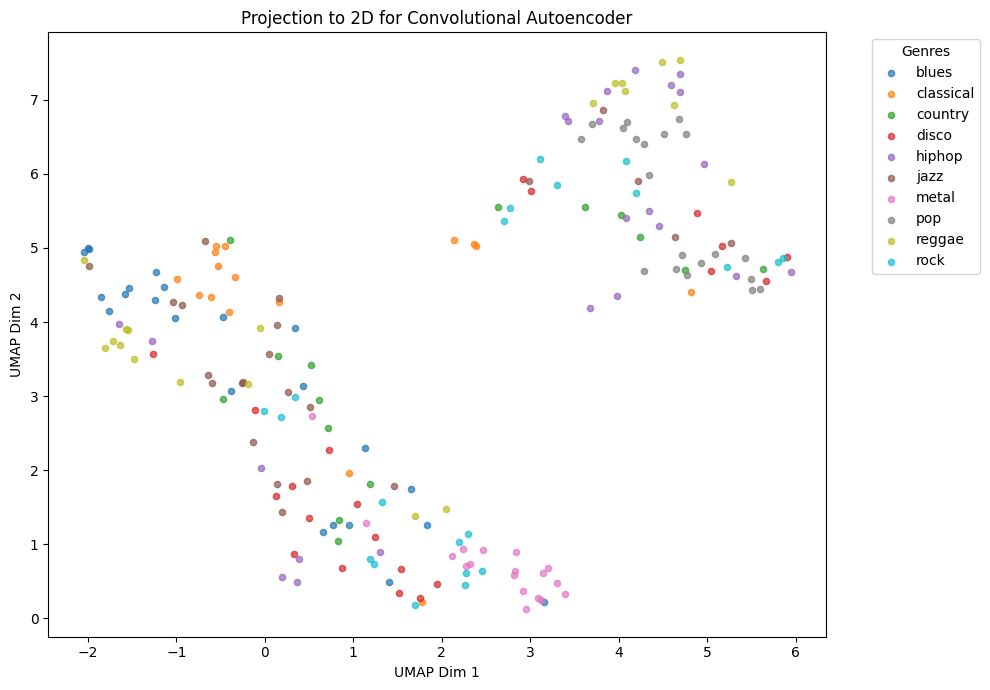

In [38]:
visualise_using_umap(model_conv1,device,val_loader,n_neighbors=10,dataset=train,min_dist=0.1, title="Projection to 2D for Convolutional Autoencoder")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


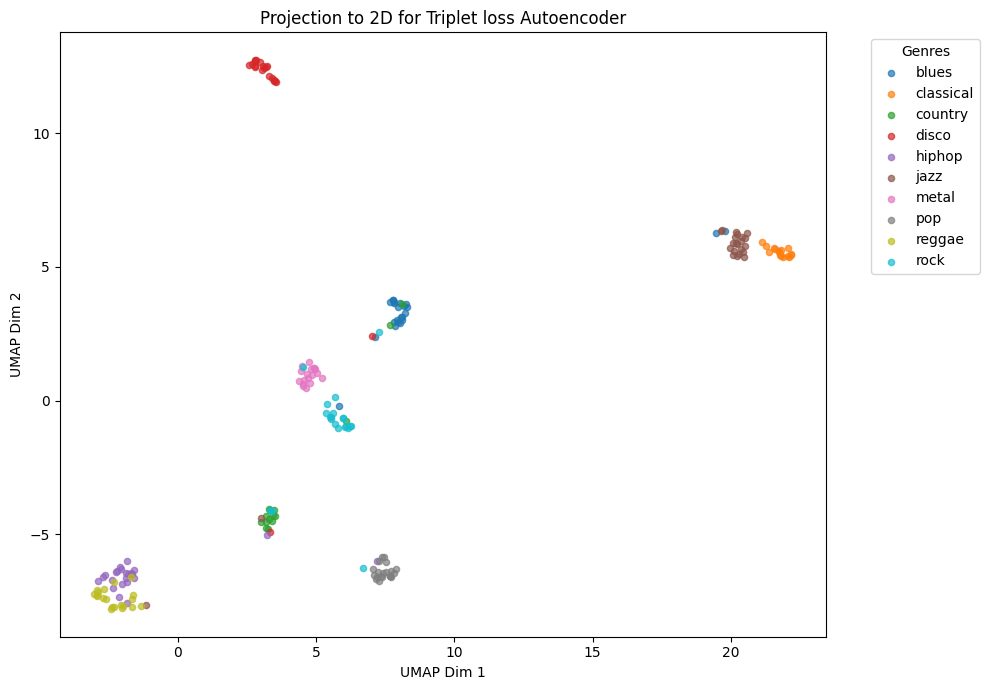

In [39]:
visualise_using_umap(model_triplet1,device,val_loader,n_neighbors=10,min_dist=0.1, dataset=train,title="Projection to 2D for Triplet loss Autoencoder")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


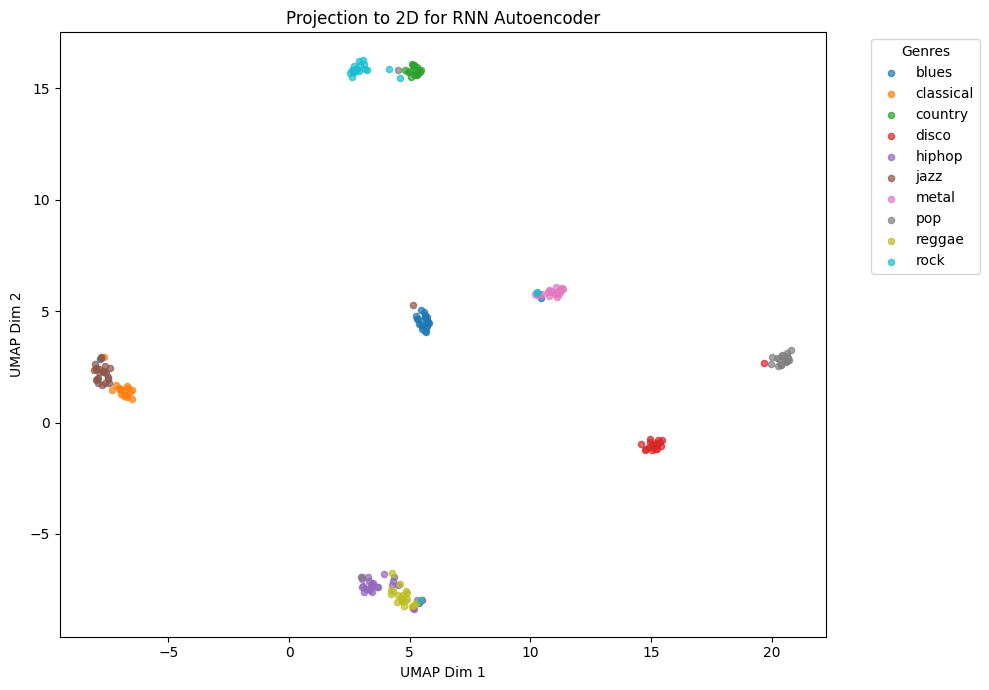

In [40]:
visualise_using_umap(model_rnn2,device,val_loader,n_neighbors=10,min_dist=0.1, dataset = train,title="Projection to 2D for RNN Autoencoder")

Embeddingy posledních dvou modelů jsou okem velmi podobné. Zároveň je možné sledovat, že se podobné žánry vyskytují blízko u sebe - např klasická hudba a jazz, nebo reggae a hiphop.